In [2]:
import pandas as pd
from transformers import pipeline
from modules.tweet_data import read_raw_data, clean_sentiment
import time
import pickle

import matplotlib.pyplot as plt


pd.options.mode.chained_assignment = None  # default='warn'

# Calculate Sentiment per tweet

In [11]:
# sentiment-analysis uses model 'distilbert-base-uncased-finetuned-sst-2-english'
# https://huggingface.co/transformers/_modules/transformers/pipelines.html#TextClassificationPipeline

# device=0 if GPU, -1 if CPU
sentiment_model = pipeline('sentiment-analysis', device=0)

In [3]:
# read data
tweet_df = read_raw_data()
# clean_sentiment function removes links, hashtags, emails and @s from each tweet
tweet_df.tweet = clean_sentiment(tweet_df.tweet)

Reading data
Filtering link
Filtering piclink
Filtering hashtag
Filtering email
Filtering add


In [15]:
# create pandas DataFrame to store sentiment measure.
sentiment = tweet_df[['tweet_id','handle']].copy()
sentiment['sentiment'] = 0
sentiment['score'] = 0

In [16]:
# Estimate sentiment per tweet. Output from sentiment model is a dictionary that indicates 'POSITIVE' or 'NEGATIVE'
# and probability of classification. Storing both in 'sentiment' and 'score' columns

t = time.time()
# Batch size of inputs to sentiment model
batch_size = 16
for i in range(0,len(tweet_df),batch_size):
    if i%10000 == 0:
        print("{}/{}, time {:.2f}".format(i, len(tweet_df),(time.time() - t)/60),end="\r")
    sentiment_dict = sentiment_model(tweet_df.tweet.iloc[i:i+batch_size].to_list())
    sentiment.sentiment.iloc[i:i+batch_size] = [1 if d['label'] == 'POSITIVE' else -1 for d in sentiment_dict]
    sentiment.score.iloc[i:i+batch_size] = [d['score'] for d in sentiment_dict]
    
print("{}/{}, time {:.2f}".format(i, len(tweet_df),(time.time() - t)/60),end="\r")

In [17]:
# Dumping sentiment DataFrame into pickle
pickle.dump( sentiment, open( "data/sentiment.p", "wb" ) )

# Sentiment Features:
    

In [ ]:
# Load sentiment DataFrame and join with user class data

sentiment = pickle.load(open( "data/sentiment.p", "rb" ))
classi = pd.read_csv('data/handle_class.csv')
sentiment = pd.merge(sentiment,classi[['class','handle','subclass']],on=['handle'], right_index=True)
sentiment.head()

In [2]:
# Load SPX data for timestamps and EDA
es = pd.read_csv('data/spx.csv')
es.Date = pd.to_datetime(es.Date +' ' +'15:45')
es.set_index('Date', inplace=True)
date_range = es['2011-12-30':'2020-5-31'].index


In [ ]:
# Function to aggregate scores. Sentiment score is sentiment (1/-1 if positive/negative) * score (probability)
def final_score(x):
    return (x.sentiment * x.score).mean()

sentiment_features = pd.DataFrame(index = date_range[1:])
# Creating bins for groupby for dates with cutoff at 3:45
date_bins = pd.cut(sentiment.index, bins=date_range)

# Daily Average
sentiment_features['daily_average'] = sentiment.groupby(date_bins).apply(final_score)

#Average by user class
class_averages = sentiment.groupby([date_bins,'class']).apply(final_score).unstack().add_prefix('daily_average_')
sentiment_features[class_averages.columns] = class_averages
del class_averages

sentiment_features['daily_average_trader'] = sentiment.groupby([date_bins,'subclass']).apply(final_score)[:,'trader']

sentiment_features.head()

In [ ]:
#Counting number of tweets per day, num_tweets. 
#The quantity is number of tweets in a day divided by the 200 day moving average of tweets in a day
# Use MA since number of tweets has increased steadily over time
# Since a weekend or holiday counts as a "day", need to standardize
# Looking at the average number of tweets for 2, 3, 4, 5 days respectively 

A = pd.DataFrame(index = date_range[1:])
A['avg'] = sentiment.groupby(date_bins).agg('count').tweet_id
A['day_diff'] = 0
A.day_diff.loc[A.index[1:]] = (A.index[1:] - A.index[:-1]).days
for i in [2,3,4,5]:
    ratio = A[A.day_diff == 1].mean()/A[A.day_diff == i].mean()
    A.loc[A.day_diff == i, 'avg'] = (ratio['avg'] * A[A.day_diff == i]['avg']).astype('int')
A = A/A.rolling(200, min_periods=1).mean()
sentiment_features['num_tweets'] = A.avg
# First few days fix at 1 for moving average burn in
sentiment_features.num_tweets.iloc[0:7] = 1
# Cap num_tweets from below at 0.8. Any lower than this usually happens in December during holidays 
sentiment_features.loc[sentiment_features.num_tweets < 0.8,'num_tweets'] =0.8

In [83]:
# Save DataFrame as sentiment_features
sentiment_features.to_csv('data/sentiment_features.csv')

# EDA

In [4]:
# Load data
sentiment_features = pd.read_csv('data/sentiment_features.csv')

sentiment_features.Date = pd.to_datetime(sentiment_features.Date)
sentiment_features.Date = sentiment_features.Date.dt.date
sentiment_features.set_index('Date',drop=True, inplace=True)

es = pd.read_csv('data/spx.csv')
es.Date = pd.to_datetime(es.Date +' ' +'15:45')
es.set_index('Date', inplace=True)

es.index = es.index.date

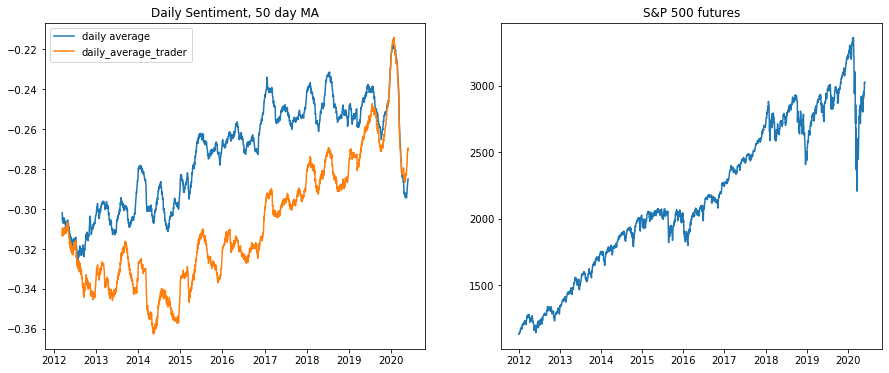

In [5]:
# Comparing sentiment to market performance. Taking 50D moving average to smooth out spikes

mkt = sentiment_features.daily_average.rolling(50).mean()
mkt2 = sentiment_features.daily_average_trader.rolling(50).mean()

fig, ax = plt.subplots(1,2,figsize=(15,6))
ax[0].plot(mkt, label='daily average')
ax[0].plot(mkt2, label='daily_average_trader')
ax[0].set_title('Daily Sentiment, 50 day MA')

ax[0].legend()

ax[1].plot(es.loc[mkt.index])
ax[1].set_title('S&P 500 futures');



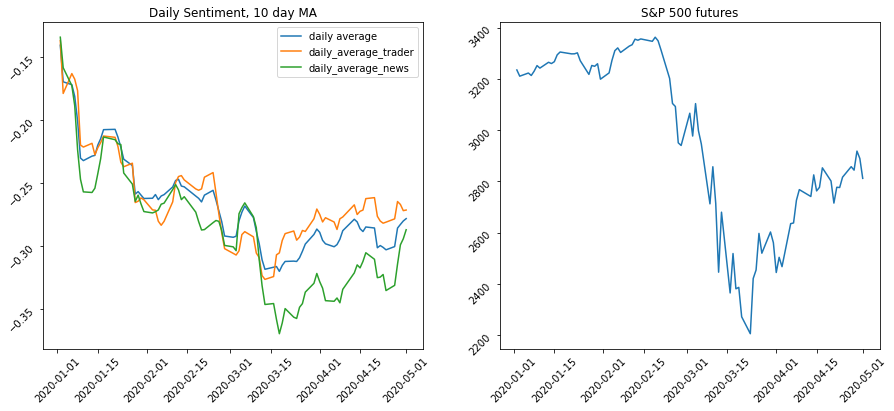

In [6]:
# Comparing sentiment to market performance during 2020. Taking 5D moving average to smooth out spikes

mkt = sentiment_features.daily_average.rolling(5).mean()
mkt2 = sentiment_features.daily_average_trader.rolling(5).mean()
mkt3 = sentiment_features.daily_average_news.rolling(5).mean()


fig, ax = plt.subplots(1,2,figsize=(15,6))
plt.xticks(rotation=90)
ax[0].plot(mkt[pd.to_datetime('2020-01-01'):pd.to_datetime('2020-05-01')], 
           label='daily average')
ax[0].plot(mkt2[pd.to_datetime('2020-01-01'):pd.to_datetime('2020-05-01')], 
           label='daily_average_trader')
ax[0].plot(mkt3[pd.to_datetime('2020-01-01'):pd.to_datetime('2020-05-01')], 
           label='daily_average_news')
ax[0].set_title('Daily Sentiment, 10 day MA')
ax[0].legend()
ax[0].tick_params(labelrotation=45)

ax[1].plot(es.loc[pd.to_datetime('2020-01-01'):pd.to_datetime('2020-05-01')])
ax[1].set_title('S&P 500 futures');
ax[1].tick_params(labelrotation=45)


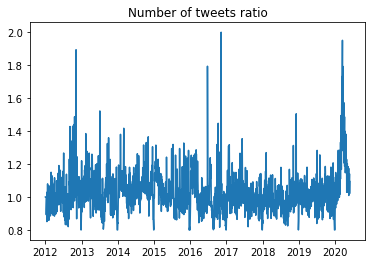

In [9]:
plt.plot(sentiment_features.num_tweets)
plt.title('Number of tweets ratio');

# Sentiment per user

In [10]:
user_features = sentiment.groupby([date_bins, 'handle']).apply(final_score).unstack()
user_features.index = sentiment_features.index

In [11]:
user_features.head()

handle,4xguy,50Pips,AFP,AJENews,AJEnglish,AJInsight,AP,AaronMehta,AlArabiya_Eng,AlbertoNardelli,...,NickGiva,WildcatTrader,HedgeDirty,RandolphDuke7,UreshP,architectrader,mitchprothero,jayho79,macrokurd,MarketElf
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03 15:45:00,0.011648,0.074823,-0.058421,-0.459384,-0.213521,-0.990219,-0.486813,-0.997481,-0.349743,-0.132478,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04 15:45:00,0.414961,-0.034361,-0.271473,-0.380858,-0.166281,NaN,-0.229093,-0.079628,-0.254802,0.008037,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05 15:45:00,-0.328351,-0.023131,-0.340646,-0.431978,-0.219482,NaN,-0.458992,-0.001567,-0.604528,-0.208913,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-06 15:45:00,0.093484,0.024120,-0.080661,-0.791466,-0.482680,NaN,-0.455284,-0.228615,-0.399301,-0.104618,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-09 15:45:00,0.000564,0.003127,-0.146910,-0.581568,-0.363977,-0.982943,-0.416436,-0.666344,-0.327697,-0.102382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
